In [1]:
import pandas as pd
import yfinance as yf

# Define tickers for Treasury yields
tickers = {'10Y': '^TNX', '5Y': '^FVX', '2Y': '^IRX'}

# Download data
start_date = "2021-01-01"
end_date = "2024-01-01"
data = {name: yf.download(ticker, start=start_date, end=end_date, interval="1mo")['Adj Close']
        for name, ticker in tickers.items()}

# Combine into a DataFrame
yield_data = pd.DataFrame(data)
yield_data.to_csv("real_yield_data.csv")

# Display sample data
print(yield_data.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

              10Y     5Y     2Y
Date                           
2021-01-01  1.093  0.443  0.048
2021-02-01  1.460  0.776  0.035
2021-03-01  1.746  0.938  0.013
2021-04-01  1.631  0.857  0.003
2021-05-01  1.581  0.788  0.008


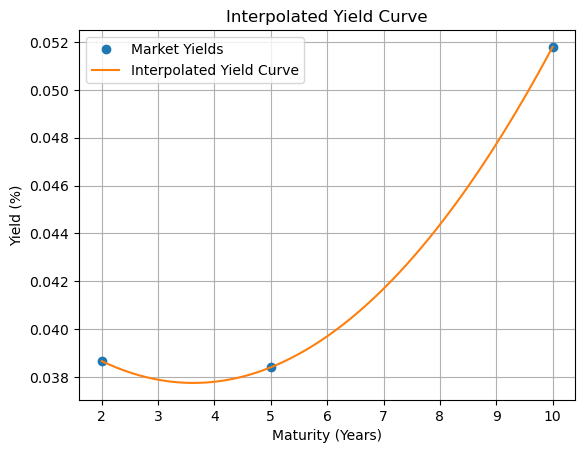

In [2]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Load real yield data
data = pd.read_csv("real_yield_data.csv", index_col=0, parse_dates=True)

# Extract yields
maturities = [2, 5, 10]  # Assume maturities for 2Y, 5Y, and 10Y
yields = data.iloc[-1].values / 100  # Most recent yields, converted to decimal

# Interpolate yield curve
cs = CubicSpline(maturities, yields)
x = np.linspace(2, 10, 100)
y = cs(x)

# Plot the yield curve
plt.plot(maturities, yields, 'o', label="Market Yields")
plt.plot(x, y, label="Interpolated Yield Curve")
plt.title("Interpolated Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid()
plt.show()


In [3]:
def price_swap(fixed_rate, forward_rates, discount_factors, notional=1e6):
    fixed_leg = sum(notional * fixed_rate * df for df in discount_factors)
    floating_leg = sum(notional * r * df for r, df in zip(forward_rates, discount_factors))
    return floating_leg - fixed_leg

# Example inputs
fixed_rate = 0.03
forward_rates = yields  # Assume yields are forward rates for simplicity
discount_factors = [np.exp(-y * t) for y, t in zip(forward_rates, maturities)]

# Price the swap
swap_value = price_swap(fixed_rate, forward_rates, discount_factors)
print(f"Present Value of the Swap: ${swap_value:,.2f}")


Present Value of the Swap: $27,934.71


In [4]:
def calculate_dv01(base_rates, shift=0.0001):
    base_df = [np.exp(-r * t) for r, t in zip(base_rates, maturities)]
    shifted_rates = [r + shift for r in base_rates]
    shifted_df = [np.exp(-r * t) for r, t in zip(shifted_rates, maturities)]
    
    base_value = price_swap(fixed_rate, base_rates, base_df)
    shifted_value = price_swap(fixed_rate, base_rates, shifted_df)
    
    return (shifted_value - base_value) / shift

dv01 = calculate_dv01(forward_rates)
print(f"DV01: ${dv01:,.2f}")


DV01: $-180,483.93
